## Imports

In [289]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree
import math

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Loading Data

Downloaded the dataset from Kaggle, containing the following files:

- train.csv (1460, 81) training set containing `X` and `y`
- test.csv (1459, 80)testing set without the associated target `y`

Loaded the training dataset into a DataFrame called `data`, and created `X` and `y`. Inspected their shapes.

Note: the train CSV file contains a column called `Id`. When reading the CSV file into a DF, I set `index_col="Id"` to avoid having two ID columns

In [290]:
data = pd.read_csv('data/train.csv', index_col = 'Id')
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [291]:
X = data.drop(columns=['SalePrice'])
y = data.SalePrice

X.shape, y.shape

((1460, 79), (1460,))

## Analysis

## Data preparation

### Duplicate removal

In [292]:
data.duplicated().sum()

0

No duplicates were found in the dataset

### Missing data

Identified the columns containing NaN (null values), expressed as a %

In [293]:
null_columns = data.isnull().sum()
percent_null_columns = (null_columns / len(data)) * 100
percent_null_columns[percent_null_columns > 0].sort_values(ascending = False)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

Went through the features containing NaNs so as to decide on a strategy

PoolQC : data description says NA means "No Pool". 

In [294]:
data["PoolQC"] = data["PoolQC"].fillna("None")

MiscFeature : data description says NA means "no misc feature"

In [295]:
data["MiscFeature"] = data["MiscFeature"].fillna("None")

Alley : data description says NA means "no alley access"

In [296]:
data["Alley"] = data["Alley"].fillna("None")

Fence : data description says NA means "no fence"

In [297]:
data["Fence"] = data["Fence"].fillna("None")

In [298]:
FireplaceQu : data description says NA means "no fireplace"

SyntaxError: invalid syntax (88026094.py, line 1)

In [299]:
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

LotFrontage relates to the linear feet of street connected to property. Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [300]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

GarageType, GarageFinish, GarageQual and GarageCond: : data description says NA means "no garage"

In [301]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

GarageYrBlt, GarageArea and GarageCars : assumed that NaN means no garage (and therefore no year of completion, area or number of cars)

In [302]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : data description says NA means "no basement"

In [303]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)

BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : assumed NaN means there is no basement as these are categorical basement-related features

In [304]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

MasVnrArea and MasVnrType : assumed NaN means no masonry veneer for these houses.

In [305]:
data["MasVnrType"] =  data["MasVnrType"].fillna("None")
data["MasVnrArea"] =  data["MasVnrArea"].fillna(0)

Electrical: since there is only 1 outlier (see below) and the majority of values in this feature (see below) correspond to SBrkr, it was assumed the remaining NaN value also corresponded to SBrkr.

In [306]:
data['Electrical'].isnull().sum()


1

In [307]:
data[['Electrical']].value_counts()/len(data[['Electrical']])

Electrical
SBrkr         0.913699
FuseA         0.064384
FuseF         0.018493
FuseP         0.002055
Mix           0.000685
dtype: float64

In [308]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

### Identifying errors

Checked for the most common error types in datasets, as seen below:

In [309]:
errors = ['?', 999, "", float('inf'), -float('inf')]
for error in errors:
    if error in data.values:
        print(f'df has {error} error')

df has 999 error


In [310]:
nine_errors = (data == 999).sum()
nine_errors[nine_errors > 0]

BsmtUnfSF      1
TotalBsmtSF    1
1stFlrSF       3
GrLivArea      3
dtype: int64

To see if the 999s are expected values or errors, I plotted each of the features with 999 values

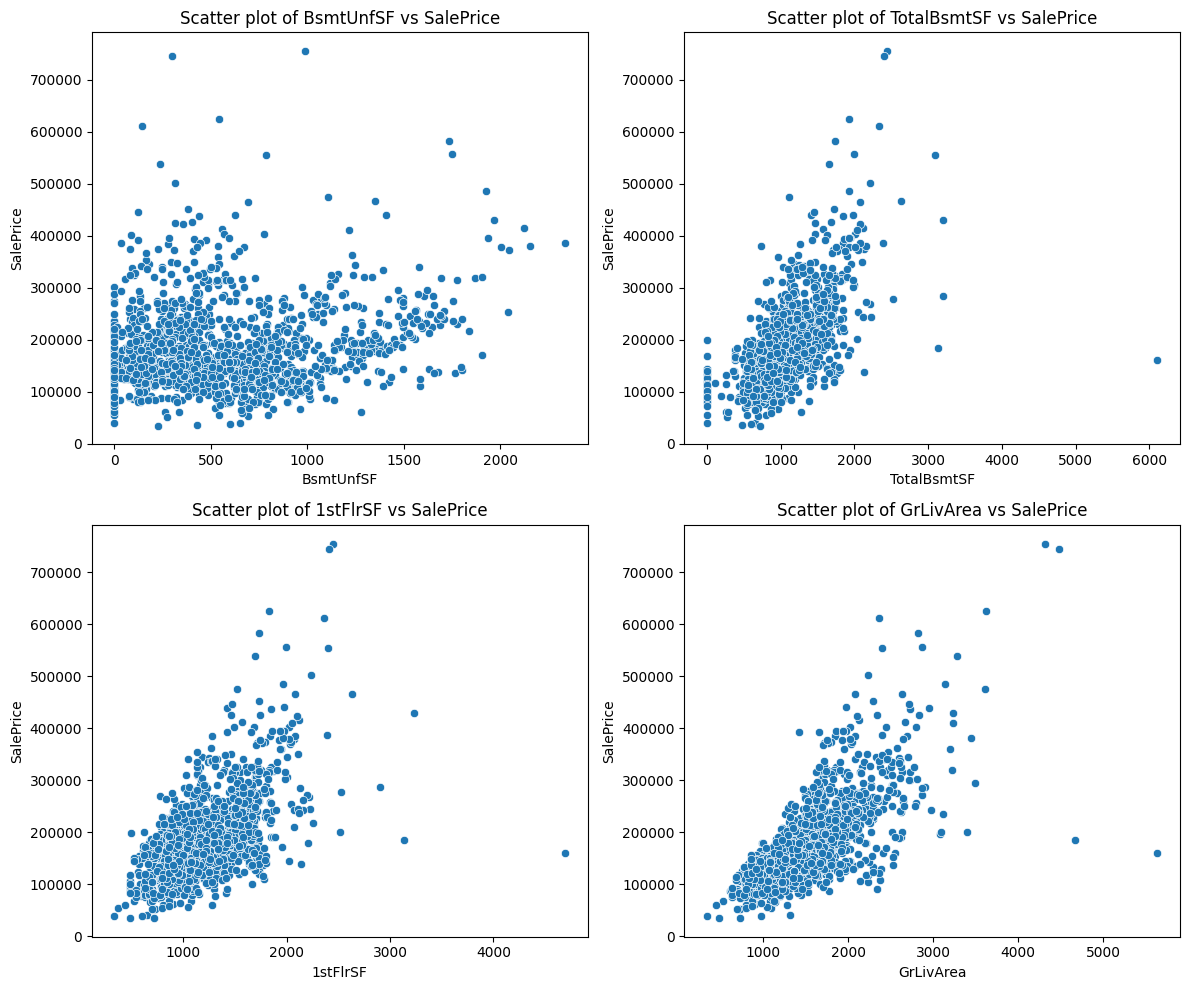

In [311]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

axes = axes.flatten()

columns = ['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']

for i, col in enumerate(columns):
    sns.scatterplot(data=data, x=col, y='SalePrice', ax=axes[i])
    axes[i].set_title(f'Scatter plot of {col} vs SalePrice')

plt.tight_layout()
plt.show()

As seen on the scatterplots above, 999 is an expected value for all 4 of the selected features. Thus, it was assumed the 999s in the dataframe are not errors.

## Creation of RMSLE metric

### Removing outliers from the target

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

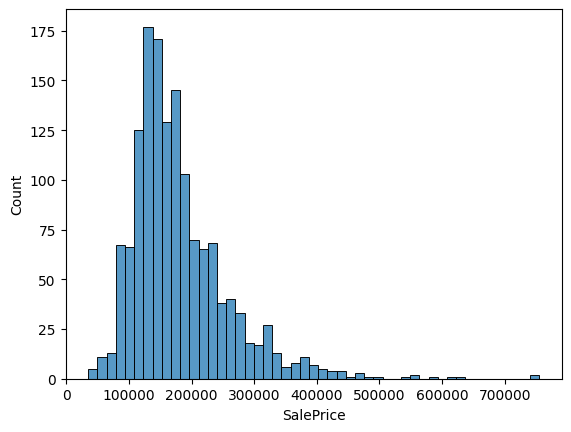

In [312]:
sns.histplot(data['SalePrice'])

As the RMSLE metric needed for the cross-validation scoring, as dictated by Kaggle, does not exist in sklearn, I created a custom sklearn.metrics.scorer object to pass to any cross-validation.

I also created its negative counterpart, `rmsle_neg`, which is best when maximised. This will be needed during GridSearchCV processes that aim at maximising a score .


RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SalePrice'>

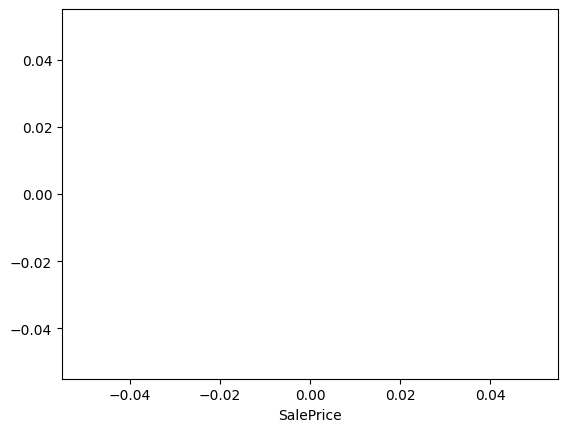

In [313]:
sns.scatterplot(data['SalePrice'])

Using Sklearn's "mean_squared_log_error"

In [314]:
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

## Preprocessing Iteration 


### Selecting a scaler

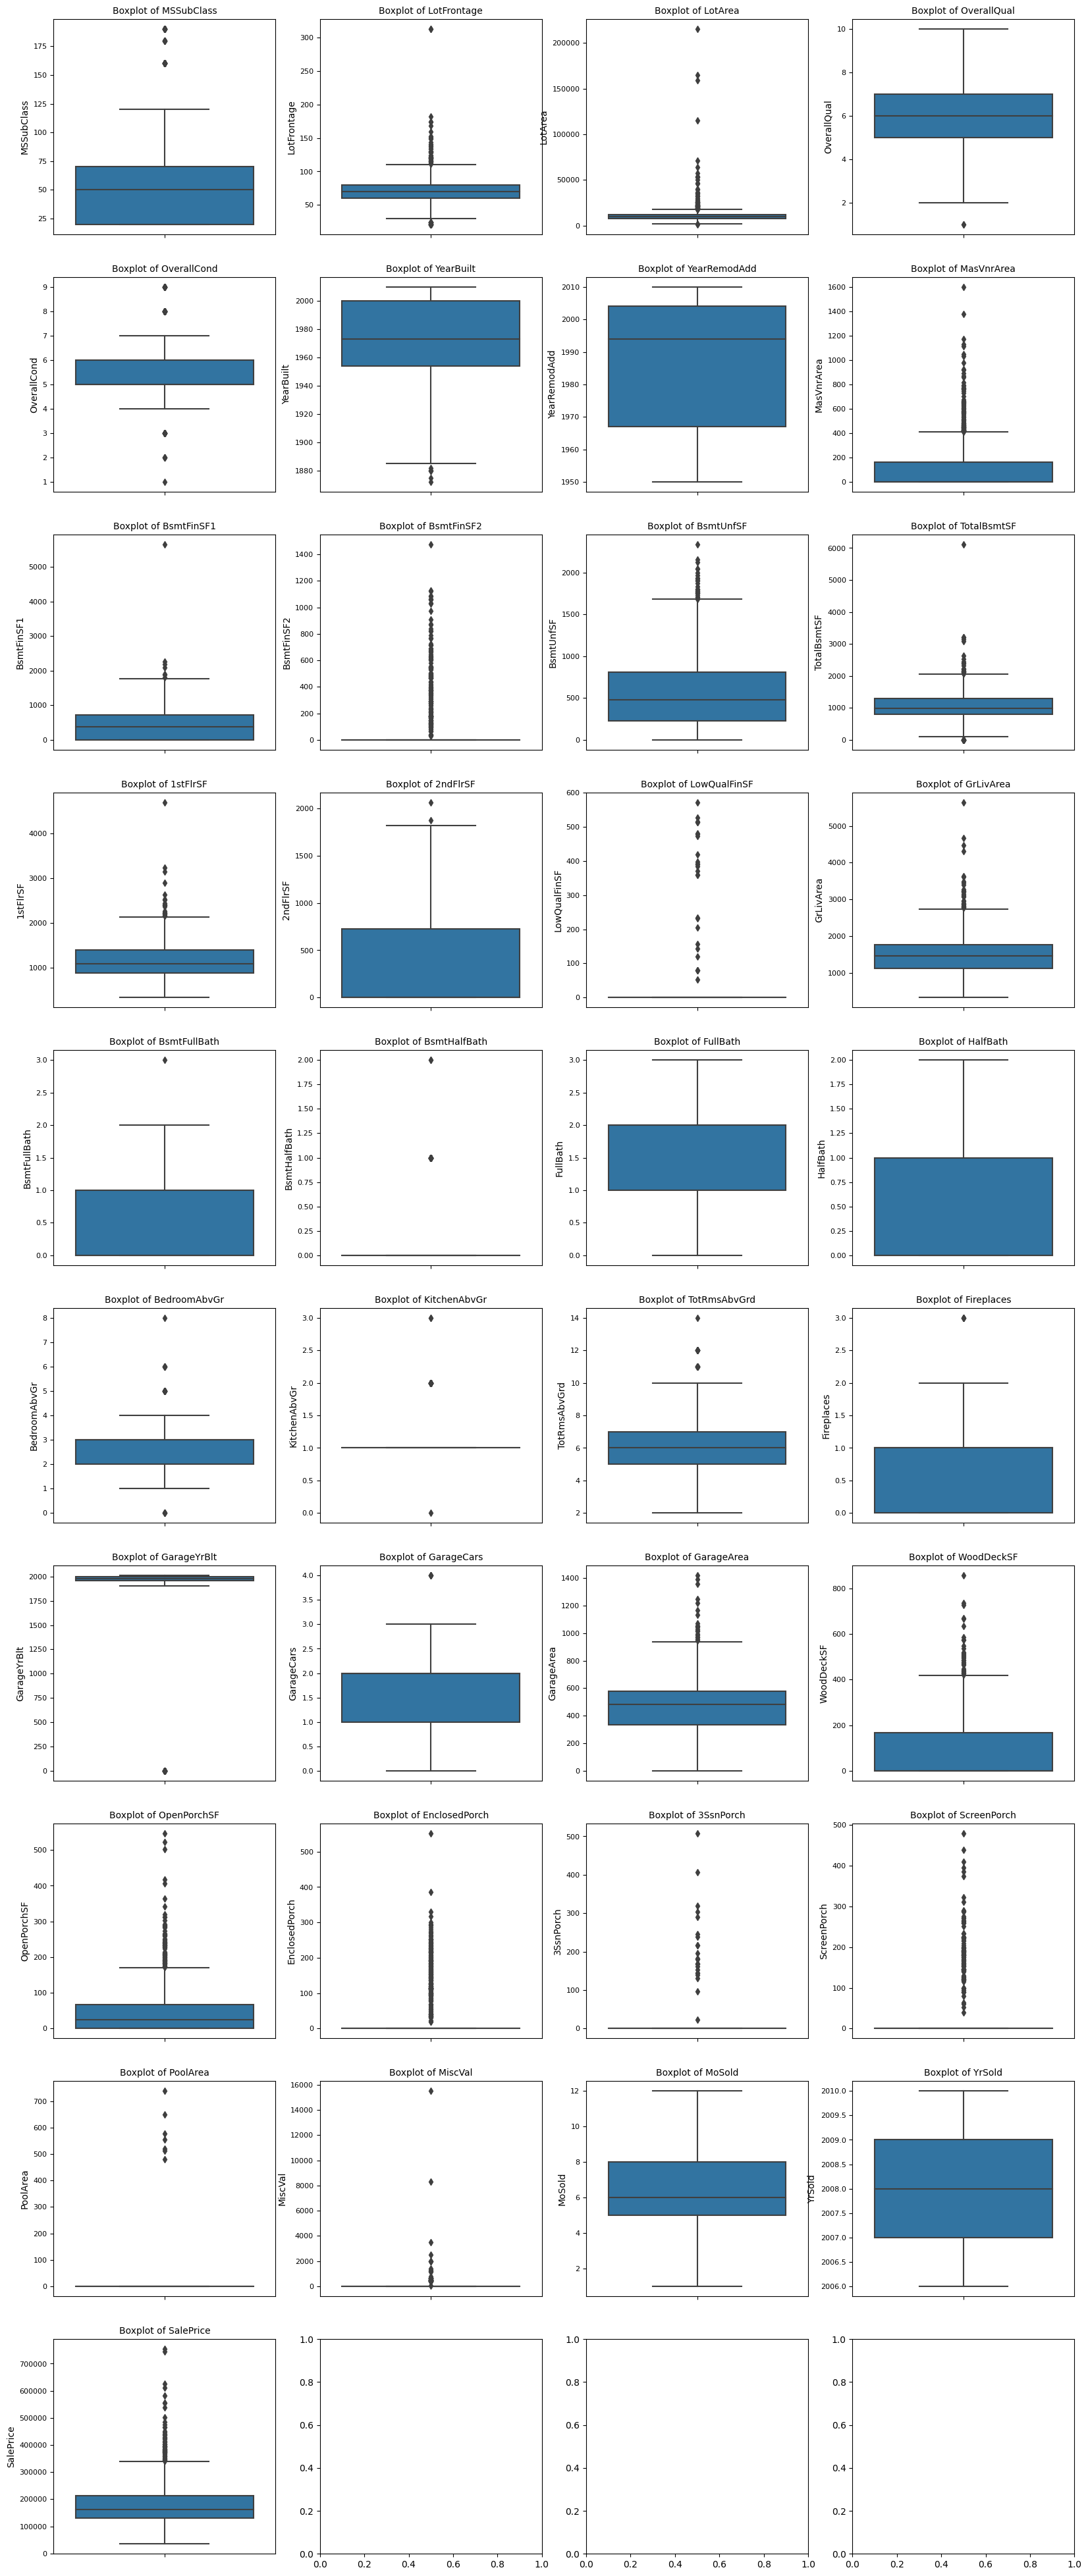

In [315]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(20, 50))

axes = axes.flatten()

data_num = data.select_dtypes(include = ['float64', 'int64'])

for i, col in enumerate(data_num.columns):
    sns.boxplot(y=data_num[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}', fontsize=10)
    axes[i].tick_params(labelsize=8)

plt.show()

Due to the high presence of outliers across the board, RobustScaler was selected as a scaler. For efficiency and simplicity, the same scaler was used across features.

### Ordinal Encoding

Some features can encoded numerically in an ordinal manner due to their inherent qualitative ranking. E.g.:


ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor



Given that, I went through the features list and manually selected the features eligible for ordinal encoding, based on their values.

Note:  "missing" was considered as "neutral"

In [345]:
feat_ordinal_dict = {
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex']
}


Ordinal column names are obtained from the dictionary's keys

In [346]:
feat_ordinal = sorted(feat_ordinal_dict.keys())
feat_ordinal

['BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Fence',
 'FireplaceQu',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'HeatingQC',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotShape',
 'PavedDrive',
 'PoolQC']

Isolated the feature values to be encoded, from the dictionary's values

In [347]:
feat_ordinal_values = sorted([feat_ordinal_dict[i] for i in feat_ordinal_col_names])
feat_ordinal_values

[['missing', 'Fa', 'Gd', 'Ex'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
 ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
 ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
 ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
 ['missing', 'N', 'P', 'Y'],
 ['missing', 'No', 'Mn', 'Av', 'Gd'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 ['missing', 'Sev', 'Mod', 'Gtl'],
 ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['missing', 'Unf', 'RFn', 'Fin']]

Built ordinal encoder for the selected features

In [348]:
ord_encoder = OrdinalEncoder(
    categories = feat_ordinal_values,
   handle_unknown="use_encoded_value", 
    unknown_value = -1)
    

Built ordinal preprocessing pipeline for eligible categorical features. For efficiency, assumed 'most_frequent 

In [349]:
preproc_ordinal = make_pipeline( 
    SimpleImputer(strategy="constant", fill_value="missing"),
    ord_encoder, 
    RobustScaler()
)
preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Fa', 'Gd', 'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Mix', 'Fu...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Sev', 'Maj2', 'Maj1',
                                             'Mod', 'Min2', 'Min1', 'Typ'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'RFn', 'Fin']],
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('robustscaler', RobustScaler())])

### Numerical Encoding

Isolated the numerical columns

In [350]:
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)


Set numerical preprocessing pipeline for numerical columns.

In [351]:
preproc_numerical = make_pipeline(
    KNNImputer(),
    RobustScaler()
)
preproc_numerical

Pipeline(steps=[('knnimputer', KNNImputer()), ('robustscaler', RobustScaler())])

### One Hot Encoding

Found the remaining categorical features that were not suitable for ordinal encoding

In [352]:
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))
feat_nominal

['Alley',
 'BldgType',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Exterior1st',
 'Exterior2nd',
 'Foundation',
 'GarageType',
 'Heating',
 'HouseStyle',
 'LotConfig',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'Neighborhood',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities']

Built nominal preprocessing pipeline for categorical features that were not ordinally encoded

In [353]:
preproc_nominal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown = 'ignore', drop="if_binary")
)

Built preprocessing pipeline for all of X using a column transformer

In [354]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

## Preprocessing X


In [355]:
pd.DataFrame(preproc.fit_transform(X, y)).head()

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,216
0,-0.453608,1.173077,0.0,0.0,0.452790,0.0,1.0,0.0,-0.559829,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.343643,0.000000,0.0,0.0,0.834679,0.0,0.0,1.0,-0.330769,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-0.327933,1.189560,0.0,0.0,0.143910,0.0,1.0,0.0,-0.074359,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.247423,1.038462,0.0,0.0,-0.235170,0.0,1.0,0.0,0.106838,272.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.113893,1.446429,0.0,1.0,0.381186,0.0,1.0,0.0,0.021368,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Statistical Feature Selection

The goal of this section is to remove the least interesting features of X to limit overfitting and shorten training time, using Sklearn's feature selection transformers. We will explore multiple options to do this.

Note: 

As we have labelled data, Option 3 - Unsupervised Selection was discarded. 

Due to computational expenses and to keep the relative simplicity of the model, Option 1 - Univariate Feature Selection was chosen over Option 2 - Multivariate Feature Selection.

#### Option 1 - Univariate Feature Selection

Removes features based on their mutual information with target `y` (statistical distance between two probability distributions).

Mutual info regression measures how much knowing a feature reduces uncertainty about the target variable. The 25% percentile ensures only 25% of all features will be kept.

In [151]:
preproc_transformer = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, 
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'BedroomAbvGr',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'BsmtUnfSF',
                                                   'EnclosedPorch',
                                                   'Fireplaces', 'FullBath',
                                                   'GarageArea', 'GarageCars',
                                                   'Gar...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x17fbc5240>))])

In [152]:
preproc.fit_transform(X, y).shape

(1460, 53)

#### Option 2 - Multivariate Feature Selection

Removes features based on their combined relationship with target `y`.

This is to remove features that do not help predict the target even when combined with all the others.

This is done using the permutation_importance metric in combination with an estimator. It trains one pipe per feature to estimate which feature makes the performance score decrease the most when shuffling it randomly. These would be the most important features, which we would want to keep.

With many features, however, this process is computationally expensive.

Thus, to trial this option, I selected sklearn's `SelectFromModel` transformer to make use of models that already output some measure of feature_importance when being fitted. For this example, I used trees with a Gini-based feature_importance.

In [153]:
preproc_transformer_multi = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector_multi = SelectFromModel(
    RandomForestRegressor(),
    threshold = "median", # drop all multivariate features lower than the median correlation
)

preproc_multi = make_pipeline(
    preproc_transformer_multi,
    preproc_selector_multi
)

preproc_multi

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x28bb85240>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   Ord...
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestRegressor(),
                                 threshold='median'))])

#### Option 3 - Unsupervised Selection
Removes features based on the properties of X

This is a quick win, to remove features with the lowest variance, e.g. a feature that only has one value is useless (and has a variance of 0).

In [154]:
def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer(
        (preproc_numerical, feat_numerical),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop"
    )

    preproc_selector = VarianceThreshold(cutoff)

    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector
    )

    return preproc.fit_transform(X).shape[1]

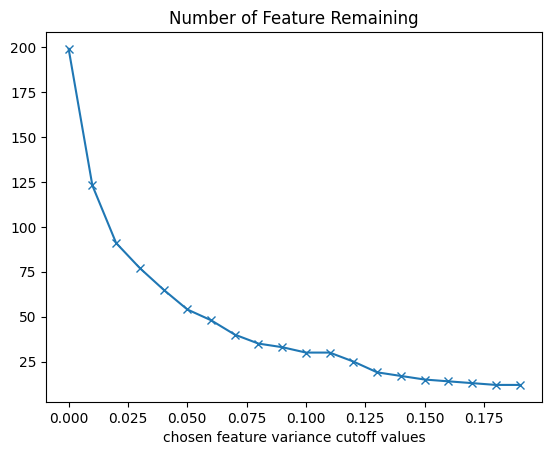

In [155]:
cutoff_values = np.arange(0, 0.2, 0.01)

plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')

plt.xlabel("chosen feature variance cutoff values")
plt.title("Number of Feature Remaining");

Based on the outcomes illustrated in the graph above, a 0.025 threshold on the categorical features could divide their number by more than half

Additionally, we can check for correlation between numerical features only:

- Using Pearson's correlation combined with a heatmap to visually check whether any numerical features almost entirely correlate with others

- Using VIF from statsmodels to check for features that have the highest multicollinearity

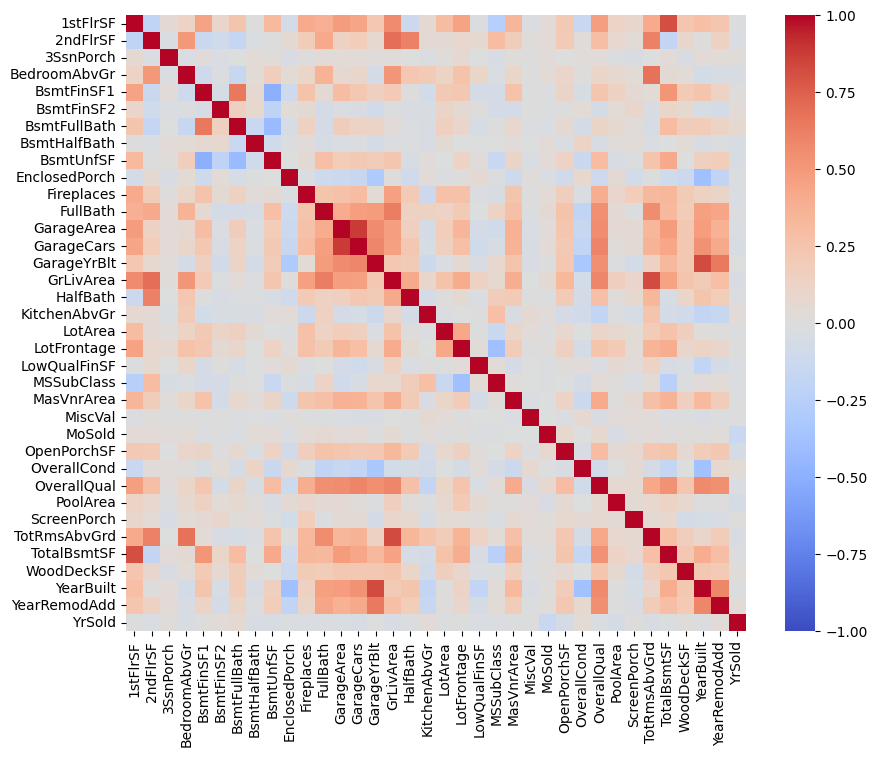

In [156]:
corr_num = X[feat_numerical].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

In [157]:
num_corr_threshold = 0.95

corr_num = X[feat_numerical].corr()
corr_num_upper_triangle = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(bool)).abs()

num_col_to_drop = [column for column in corr_num_upper_triangle.columns if any(corr_num_upper_triangle[column] > num_corr_threshold)]
num_col_to_drop

[]

For ordinal features, we can use Spearman's rank correlation instead to check whether some ordinally encoded features are almost entirely "ordered" similarly to others.

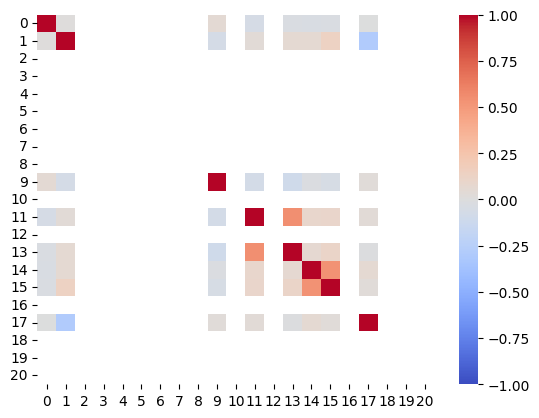

In [76]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]))

sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1);

We may create a "filter" in the pipeline that removes any feature beyond a given (Spearman + Pearson) correlation threshold; with a custom transformer class.

In [61]:
class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_corr_threshold=0.95):
        self.num_corr_threshold = num_corr_threshold

    def fit(self, X, y=None):
        feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

        corr_num = X[feat_numerical].corr()
        upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(bool)).abs()

        self.num_col_to_drop = [column for column in upper.columns if any(upper[column] > self.num_corr_threshold)]
        self.num_col = X[feat_numerical].columns

        return self

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.num_col)

        return df.drop(columns=self.num_col_to_drop)

# Test it here
CustomFeatureSelector(num_corr_threshold=0.2).fit_transform(X[feat_numerical]).head(2)

,1stFlrSF,3SsnPorch,BsmtFinSF2,BsmtHalfBath,EnclosedPorch,KitchenAbvGr,LowQualFinSF,MiscVal,MoSold,ScreenPorch,YrSold
Id,,,,,,,,,,,
1,856,0,0,0,0,1,0,0,2,0,2008
2,1262,0,0,1,0,1,0,0,5,0,2007


As stated above, Option 1 - Univariate Feature Selection will be used throughout the model going forwards.

### Treat Cyclical Features

Some features are time-based, thus we must transform them into cyclical features

In [78]:
months_in_a_year = 12

X['sin_MoSold'] = np.sin(2 * np.pi * (X.MoSold - 1) / months_in_a_year)
X['cos_MoSold'] = np.cos(2 * np.pi * (X.MoSold - 1) / months_in_a_year)

X.drop(columns=['MoSold'], inplace=True)

X.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,sin_MoSold,cos_MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,0.500000,0.866025
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2007,WD,Normal,0.866025,-0.500000
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.866025,-0.500000
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2006,WD,Abnorml,0.500000,0.866025
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.500000,0.866025


### Target Engineering

The distribution of the target y is skewed. 

As we are asked to minimise the RMSLE, we may transform the target to directly predict its log. 
As the distribution of the log(y) is normal, we may use linear or parametric models as these are better suited to predicting normally distributed variables.

Where log(y) is used, we will take the exponent of the predictions at the end

Text(0.5, 0, 'log(SalePrice)')

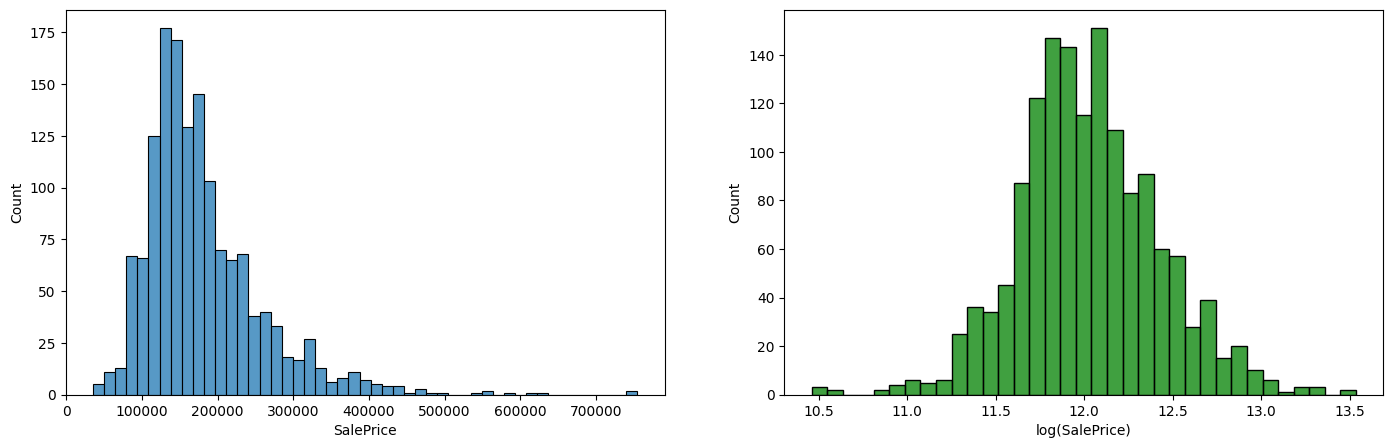

In [79]:
y_log = np.log(y)

plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
sns.histplot(y)

plt.subplot(1, 2, 2)
sns.histplot(y_log, color='green')

plt.xlabel("log(SalePrice)")

Created new scorers to minimise or maximise (when applicable)

In [86]:
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

## Model Iteration

As  GridSearching would be too time-consuming, I went model by model to decide which one delivers the best RMSE, through comparing the cross-validated scores of different models.

Incorporated Univariate Feature Selection into the preproc timeline

In [342]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value = -1
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    RobustScaler(), 
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    RobustScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder= "drop")


preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only xx% of all features )
)
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'BedroomAbvGr',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'BsmtUnfSF',
                                                   'EnclosedPorch',
                                                   'Fireplaces', 'FullBath',
                                                   'GarageArea', 'GarageCars',
                                                   'Gara...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x17fbc5240>))])

### Linear models

Set boolean to activate or deactivate GridSearch in cells below

In [343]:
allow_grid_searching = True

Set cachedir = mkdtemp() to avoid redundant computations in the preprocessing step of the pipeline

In [344]:
 cachedir = mkdtemp()

#### Ridge with normal target


In [330]:
model = Ridge()

pipe_ridge = make_pipeline(preproc, model)

cross_val_score(pipe_ridge, X, y, cv=5, scoring=rmsle).mean()

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 533, in fit_transform
    Xt = self._fit(X, y, routed_params)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 976, in fit_transform
    result = self._call_func_on_transformers(
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 885, in _call_func_on_transformers
    return Parallel(n_jobs=self.n_jobs)(jobs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 74, in __call__
    return super().__call__(iterable_with_config)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 136, in __call__
    return self.function(*args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 533, in fit_transform
    Xt = self._fit(X, y, routed_params)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py", line 1482, in fit
    raise TypeError(
TypeError: unknown_value should be an integer or np.nan when handle_unknown is 'use_encoded_value', got None.


#### Ridge with log target

In [100]:
model = Ridge()

pipe_ridge = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.1473512743615262

GridSearch the Ridge regularisation

In [96]:
if allow_grid_searching:
    param_grid =  {'ridge__alpha': np.linspace(0.5, 2, num=20)}

    search_ridge = GridSearchCV(
        pipe_ridge,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_ridge.fit(X, y_log);

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_ridge.best_params_}')
    print(f'Best score 👉 {search_ridge.best_score_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform.

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform.


----------------------------------------

Best params 👉 {'ridge__alpha': 1.526315789473684}
Best score 👉 -0.1472277227651914


#### KNN

In [97]:
model = KNeighborsRegressor()

pipe_knn = make_pipeline(preproc, model)

In [80]:
scores = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse)
scores.mean()

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [6, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5, 21] during transf

0.2168014849655052

GridSearch the KNN

In [98]:
if allow_grid_searching:
    param_grid =  {'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}

    search_knn = GridSearchCV(
        pipe_knn,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_knn.fit(X, y_log);

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_knn.best_params_}')
    print(f'Best score 👉 {search_knn.best_score_}')

Fitting 3 folds for each of 11 candidates, totalling 33 fits


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9, 13] during


----------------------------------------

Best params 👉 {'kneighborsregressor__n_neighbors': 15}
Best score 👉 -0.21990906885518688


#### SVM

In [102]:
model = SVR(kernel='linear')

pipe_svm = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.14491324381206316

In [103]:
model = SVR(kernel='rbf', C = 10)

pipe_svm_rbf = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.14760853946462996

GridSearch the SVM

In [104]:
if allow_grid_searching:
    param_grid =  {
        'svr__C': [0.5, 0.7, 1, 2, 5, 10],
        'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
        #'svr__coef0': [0.0, 0.1, 0.5,1],
    }

    search_svm_rbf = GridSearchCV(
        pipe_svm_rbf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_svm_rbf.fit(X, y_log);

    svm_rbf_best = search_svm_rbf.best_estimator_

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_svm_rbf.best_params_}')
    print(f'Best score 👉 {search_svm_rbf.best_score_}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform.

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during tra

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform.


----------------------------------------

Best params 👉 {'svr__C': 0.7, 'svr__epsilon': 0.05}
Best score 👉 -0.13193036549202777


#### Trees

In [105]:
model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.00956029783629652
0.18782951017097094


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Random Forest

In [107]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.007686382849674283
0.16344846556518722


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Boosted Trees

In [108]:
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.009126440623124139
0.1447837511518935


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [109]:
model = GradientBoostingRegressor(n_estimators=100, verbose=0)

pipe_gb = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.007167121604174511
0.1301782320920359


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


For efficiency, focused on the two key parameters and commented out the rest, so as to illustrate other potential applications of GridSearch in this particular case

In [111]:
if allow_grid_searching:
    grid = {
          'gradientboostingregressor__n_estimators': stats.randint(50,300),
          # 'gradientboostingregressor__learning_rate': stats.uniform(0.05, 0.3),
          # 'gradientboostingregressor__loss': ['lad', 'huber', 'quantile'],
          # 'gradientboostingregressor__max_depth': stats.randint(3, 5),
          # 'gradientboostingregressor__min_samples_split': stats.randint(2, 10),
          # 'gradientboostingregressor__subsample': [0.95, 1], # 1 default
          'gradientboostingregressor__max_features': stats.randint(1, len(X.columns)) # default None, i.e = n_features
     }

    search_gb = RandomizedSearchCV(pipe_gb, grid, scoring=rmse_neg, n_iter=8, cv=5, n_jobs=1, verbose=2)
    # Fit data to GridSearch
    search_gb.fit(X, y_log)
    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_gb.best_params_}')
    print(f'Best score 👉 {search_gb.best_score_}')
    

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=102; total time=   0.3s
[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=102; total time=   0.4s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=102; total time=   0.3s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=102; total time=   0.4s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=102; total time=   0.4s
[CV] END gradientboostingregressor__max_features=63, gradientboostingregressor__n_estimators=100; total time=   0.4s
[CV] END gradientboostingregressor__max_features=63, gradientboostingregressor__n_estimators=100; total time=   0.4s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=63, gradientboostingregressor__n_estimators=100; total time=   0.4s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=63, gradientboostingregressor__n_estimators=100; total time=   0.4s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=63, gradientboostingregressor__n_estimators=100; total time=   0.4s
[CV] END gradientboostingregressor__max_features=69, gradientboostingregressor__n_estimators=168; total time=   0.7s
[CV] END gradientboostingregressor__max_features=69, gradientboostingregressor__n_estimators=168; total time=   0.7s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=69, gradientboostingregressor__n_estimators=168; total time=   0.7s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=69, gradientboostingregressor__n_estimators=168; total time=   0.6s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=69, gradientboostingregressor__n_estimators=168; total time=   0.6s
[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=279; total time=   0.8s
[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=279; total time=   0.8s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=279; total time=   0.8s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=279; total time=   0.7s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=39, gradientboostingregressor__n_estimators=279; total time=   0.7s
[CV] END gradientboostingregressor__max_features=53, gradientboostingregressor__n_estimators=269; total time=   0.9s
[CV] END gradientboostingregressor__max_features=53, gradientboostingregressor__n_estimators=269; total time=   0.9s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=53, gradientboostingregressor__n_estimators=269; total time=   0.8s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=53, gradientboostingregressor__n_estimators=269; total time=   0.8s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=53, gradientboostingregressor__n_estimators=269; total time=   0.9s
[CV] END gradientboostingregressor__max_features=44, gradientboostingregressor__n_estimators=131; total time=   0.4s
[CV] END gradientboostingregressor__max_features=44, gradientboostingregressor__n_estimators=131; total time=   0.4s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=44, gradientboostingregressor__n_estimators=131; total time=   0.4s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=44, gradientboostingregressor__n_estimators=131; total time=   0.4s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=44, gradientboostingregressor__n_estimators=131; total time=   0.4s
[CV] END gradientboostingregressor__max_features=45, gradientboostingregressor__n_estimators=157; total time=   0.5s
[CV] END gradientboostingregressor__max_features=45, gradientboostingregressor__n_estimators=157; total time=   0.5s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=45, gradientboostingregressor__n_estimators=157; total time=   0.5s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=45, gradientboostingregressor__n_estimators=157; total time=   0.5s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=45, gradientboostingregressor__n_estimators=157; total time=   0.6s
[CV] END gradientboostingregressor__max_features=36, gradientboostingregressor__n_estimators=183; total time=   0.5s
[CV] END gradientboostingregressor__max_features=36, gradientboostingregressor__n_estimators=183; total time=   0.5s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=36, gradientboostingregressor__n_estimators=183; total time=   0.6s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=36, gradientboostingregressor__n_estimators=183; total time=   0.5s


/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END gradientboostingregressor__max_features=36, gradientboostingregressor__n_estimators=183; total time=   0.6s

----------------------------------------

Best params 👉 {'gradientboostingregressor__max_features': 39, 'gradientboostingregressor__n_estimators': 279}
Best score 👉 -0.12938529786141756


#### XGBoost

Created eval test just for early-stopping purposes

In [112]:
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X, y_log, random_state=42)

In [113]:
model_xgb = XGBRegressor(max_depth=10,
                         n_estimators=300,
                         eval_metric=["rmse"],
                         learning_rate=0.1)

In [114]:
pipe_xgb = make_pipeline(preproc, model_xgb)

cross_val_score(pipe_xgb, X, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()

/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/irenegracia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.13779225720890284

Instantiating with early stopping criteria

In [116]:
model_xgb_early_stopping = XGBRegressor(max_depth=10,
                         n_estimators=300,
                         eval_metric=["rmse"],
                         learning_rate=0.1,
                        early_stopping_rounds=10)

Best Validation Score 0.14489589210326576


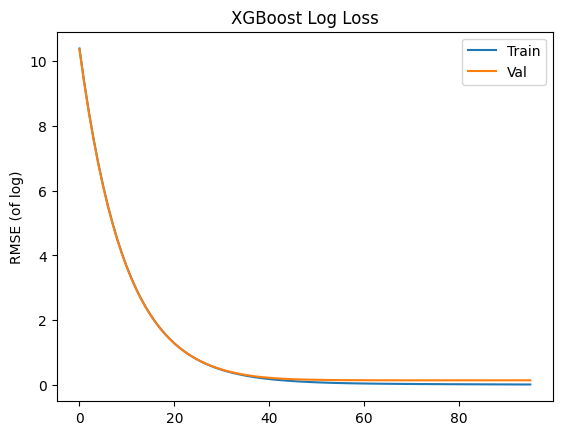

In [117]:
X_train_preproc = preproc.fit_transform(X_train, y_train_log)
X_eval_preproc = preproc.transform(X_eval)

model_xgb_early_stopping.fit(
    X_train_preproc,
    y_train_log,
    verbose=False,
    eval_set=[(X_train_preproc, y_train_log), (X_eval_preproc, y_eval_log)],
)

# Retrieve performance metrics
results = model_xgb_early_stopping.evals_result()
epochs = len(results['validation_0']["rmse"])
x_axis = range(0, epochs)

# Plot RMSLE loss
fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend(); plt.ylabel('RMSE (of log)'); plt.title('XGBoost Log Loss')

print("Best Validation Score", min(results['validation_1']['rmse']))

## Conclusion: best model 

Based on this iteration, the best model was Boosted Trees with the following parameters and scores:


In [121]:
print(f'Best params: {search_gb.best_params_}')
print(f'Best score: {search_gb.best_score_}')

Best params: {'gradientboostingregressor__max_features': 39, 'gradientboostingregressor__n_estimators': 279}
Best score: -0.12938529786141756


## Calculation of test results

Loaded the test set

In [122]:
X_test = pd.read_csv('data/test.csv')

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

Added cyclicality to the relevant features 

In [123]:
X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

X_test.drop(columns=['MoSold'], inplace=True)

Predicted y_test using the best estimator found

In [124]:
pipe_gb.fit(X, y_log)

Pipeline(memory='/var/folders/f5/09ncy7_d4vd9xjdxvm7rvkqc0000gn/T/tmp9yo5wb0a',
         steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x17728f5e0>),
                                                                  ('pipeline-2...
                                                                                                  handle_unknown='ignore'))]),
                                                                   ['Alley',
                                                                    'BldgType',
                                                                    'CentralAir',
                                                                    'Foundation',
                                                                    'GarageType',
                                                                    'Heating',
                                                                    'LotConfig',
                                                                    'MSZoning',
                                                                    'MasVnrType',
                                                                    'MiscFeature',
                                                                    'RoofStyle',
                                                                    'SaleCondition',
                                                                    'Street',
                                                                    'Utilities'])])),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=50,
                                                   score_func=<function mutual_info_regression at 0x17fbc5240>))])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [125]:
predictions_log = pipe_gb.predict(X_test)
predictions = np.exp(predictions_log)

In [126]:
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results

,Id,SalePrice
0,1461,123641.145878
1,1462,160680.550004
2,1463,181212.787035
3,1464,183903.527244
4,1465,194040.420872
...,...,...
1454,2915,76288.104220
1455,2916,83616.248413
1456,2917,160472.485588
1457,2918,115074.115321


Cleared the cache directory at the end

In [127]:
rmtree(cachedir)